# [IAPR][iapr]: Lab 2 ‒  Object description (old)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [71]:
import tarfile
import os
import albumentations as A
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from skimage import transform

# increase recursive depth limit just in case
import sys
sys.setrecursionlimit(6000)

os.pardir = '/Users/berkay/OneDrive/EPFL_COURSES/EE451/LABS/iapr/data'

data_base_path = os.path.join(os.pardir, '')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [72]:
class region_growing():
    
    """class to perform region growing, borrowed from our written submission for lab 2
    """
    
    def __init__(self, img):
        
        self.img = img
        self.height = img.shape[0]
        self.width = img.shape[1]
        self.size = 0
        self.coor = 0
        self.signal = []
        
        # if img is in greyscale, region is also in greyscale
        if len(img.shape) == 2: 
            self.region = np.zeros((self.height, self.width), dtype=np.int32)
        else:
            num_channels = img.shape[2]
            self.region = np.zeros((self.height, self.width, num_channels), dtype=np.float64)

    
    def grow_region(self, x, y, threshold):
        """
            Function for region growing for greyscale images.
        """
        current_pixel = self.img[x, y]
        self.signal.append([x, y])
        self.region[x, y] = current_pixel
        self.size += 1
        
        # iterate over neighbour pixels 
        for i in range(max(x - 1, 0), min(x + 2, self.height)):
            for j in range(max(y - 1, 0), min(y + 2, self.width)):
                
                # return if the pixel is black
                #if self.img[i, j] == 0:
                    #return
                # if neighbour pixel is similar and that neighbour pixel is not part of the region
                if abs(int(self.img[i, j]) - int(current_pixel)) <= threshold and self.region[i, j] == 0:
                    self.grow_region(i, j, threshold)
                    
                    
    def grow_region_lab(self, x, y, threshold):
        """
            Function for region growing for LAB images.
        """
        current_pixel = self.img[x, y]
        self.size += 1
        
        self.region[x, y] = current_pixel 
        for i in range(max(x - 1, 0), min(x + 2, self.height)):
            for j in range(max(y - 1, 0), min(y + 2, self.width)):
                if skimage.color.deltaE_cie76(current_pixel, self.img[i, j]) <= threshold and np.all(self.region[i, j] == 0.0):
                    self.grow_region_lab(i, j, threshold)
        return
    
                             
    def draw_region(self, ax, threshold):
        
        ax.imshow(self.region, cmap='gray')
        ax.set_title('Region Size = {}'.format(self.calculate_region_area()))
        ax.set_xlabel(f'threshold = {threshold}')


        
    def calculate_region_area(self):
        return self.height * self.width - np.sum(self.region == 0)
    
    
    def region2lst(self):
        """
            returns non-zero pixel values of the region in a list
        """
        lst = []
        for x in range(self.region.shape[0]):
            for y in range(self.region.shape[1]):
                if not np.all(self.region[x, y] == 0.0):
                    lst.append((x, y))
        return lst

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

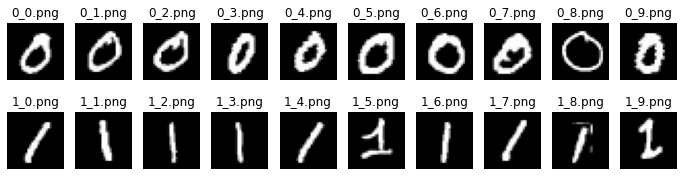

In [73]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

# Part 1.1 
## Implementation of Fourier Descriptors

Before the generalized code for all images, the preprocessing steps are shown in one image.

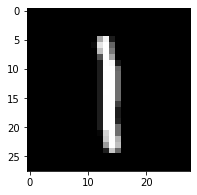

In [74]:
first_zero = ones_im[3]
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(first_zero, cmap='gray')

First, image binarization is done by assigning 255 to the pixel values that are larger than the threshold and assigning 0 to the pixels below the threshold.

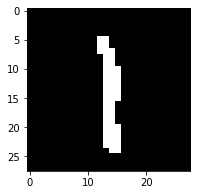

In [75]:
binary_first_zero = np.zeros([np.shape(first_zero)[0], np.shape(first_zero)[1]])
binary_first_zero[np.where(first_zero > 102)] = 255
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(binary_first_zero, cmap='gray')

Erosion operation from morphological transformations is preferred since we wanted to decrease the thickness of the object, which allows us to differentiate the '0' and '1' contours more. 

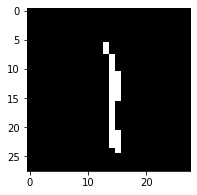

In [76]:
"Erosion"
kernel = np.ones((2,2), np.uint8)
dilation = cv.erode(binary_first_zero,kernel,iterations = 1)
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(dilation, cmap='gray')

Contour of the image is found by OpenCV function *findContours* and drawn with *drawContours* function. Only the external contour is taken into consideration. 

[13  6]


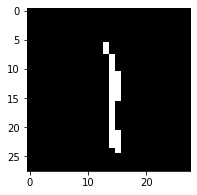

In [77]:
"Contour Detection"
import cv2 as cv
contours, hierarchy = cv.findContours(np.uint8(dilation).copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
out = np.zeros_like(binary_first_zero)
cv.drawContours(out, contours, -1, 255, 1)
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(out, cmap='gray')
#print(contours)
first_pix = contours[0][0][0]
print(first_pix)

In this function, the image is binarized with respect to the given threshold. Afterwards, erosion operation is applied to make the object thinner. Lastly, the outer contour is detected.

In [78]:
def extract_contours(one_ims, thr):
    
    """returns a tuple including binary images with edges being 255 and the rest 0
    and the coordinates of the edges
    """
    imgs_contours = []
    
    for i in range(one_ims.shape[0]):
        binarized = np.zeros([np.shape(one_ims[i])[0], np.shape(one_ims[i])[1]])
        # binarize the image given the threshold
        binarized[np.where(one_ims[i] > thr)] = 255
        
        # perfom erosion
        kernel = np.ones((2,2), np.uint8)
        dilation = cv.erode(binarized, kernel, iterations = 1)
        
        # extract the outer edge and coordinates of the edge
        contour, hierarchy = cv.findContours(np.uint8(dilation).copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        img = np.zeros_like(binarized)
        cv.drawContours(img, contour, -1, 255, 1)
        
        imgs_contours.append((img, contour))
    return imgs_contours

Here, we resize the images (doubling the dimensions) to increase the resolution. Cubic interpolation is preferred for better approximation.

In [79]:
# double the width and height of each image
dim = (28*2, 28*2)
resized_zeros = np.zeros((10,28*2,28*2))
resized_ones = np.zeros((10,28*2,28*2))
for i in range(10):
    resized_zeros[i,:,:] = cv.resize(zeros_im[i,:,:], dim, interpolation = cv.INTER_CUBIC)
    resized_ones[i,:,:] = cv.resize(ones_im[i,:,:], dim, interpolation = cv.INTER_CUBIC)

In [80]:
# extract information about edge
one_ims = extract_contours(resized_ones, 120)
zero_ims = extract_contours(resized_zeros, 120)

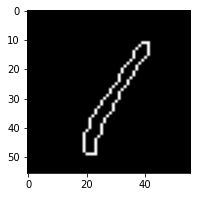

In [81]:
# a sample showing the extracted image
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(one_ims[0][0], cmap='gray')

To be able to implement Fourier descriptors, we need the contour coordinates in successive order. Hence, we utilized **region_growing** class.

In [82]:
def img2signal(img, x, y):
    
    """given the starting coordinate x, y perform region growing to have the coordinates of the contour IN ORDER
    """
    
    start = x, y
    region = region_growing(img)
    region.grow_region(*start, 0.0)
    print(region.size)
    
    return region.signal

After obtaining the successive coordinates of the contour, we need to transform these coordinates to complex signal. \\
For each {$x_k,y_k$} on the contour,
$$ u_k = x_k + jy_k $$

In [83]:
def build_complex_signal(region):
    """from the ordered coordinates of the object build the complex signal representing the image
    """
    c_signal = []
    for elm in region:
        c_signal.append([elm[0], elm[1]*1j])
    return c_signal

Having the complex signal, Fourier transform is calculated. The amplitudes of Fourier coefficients are taken, which makes the descriptors invariant to rotation and translation. Fourier coefficients are normalized, which makes the descriptors invariant to scaling. 

In [84]:
def extract_fse(signal):
    """for a given image signal calculates DFT and returns amplitude of 
       first five coefficients normalized by the amplitude of a chosen coefficient 
    """ 
    
    fse = np.fft.fft(signal,500)
    first_c, second_c, third_c, fourth_c, fifth_c = fse[1:6,:]
    norm_fac = np.linalg.norm(fse[5,:])
    
    first_c_norm = np.linalg.norm(first_c)    
    second_c_norm = np.linalg.norm(second_c)
    third_c_norm = np.linalg.norm(third_c)
    fourth_c_norm = np.linalg.norm(fourth_c)
    fifth_c_norm = np.linalg.norm(fifth_c)
    
    return first_c_norm/norm_fac, second_c_norm/norm_fac, third_c_norm/norm_fac, fourth_c_norm/norm_fac, fifth_c_norm/norm_fac

In [85]:
def extract_features_one(ones_data, one_flag=False):
    """extracts fourier coefficients for a given batch of image.
    """
    features = []
    for i in range(len(ones_data)):
        img = ones_data[i][0]
        contour = ones_data[i][1]
        if i == 8 and one_flag:
            y, x = contour[1][0][0] 
        else:
            y, x = contour[0][0][0]
        fse_c = img2signal(img, x, y)
        sig = build_complex_signal(fse_c)
        
        features.append(extract_fse(sig))
    return features

In [86]:
# extract features for ones
features_one = extract_features_one(one_ims, one_flag=False)
features_zero = extract_features_one(zero_ims)

81
83
77
77
81
144
78
83
69
107
93
93
94
91
94
109
102
101
106
100


In [87]:
f_one = np.array(features_one)
f_zero = np.array(features_zero)

Low frequency components of Fourier transform are considered since they convey more information regarding to the shape in the image. \\
As can be seen from the figure, '0' and '1' images are clustered in different regions. 

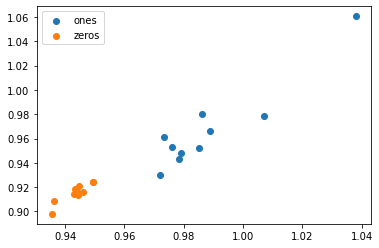

In [88]:
plt.figure()
# take second and third fourirer coefficients as the features
plt.scatter(f_one[:,2], f_one[:,1])
plt.scatter(f_zero[:,2], f_zero[:,1])
plt.legend(['ones','zeros'])

As seen in the above figure, 0s have lower inter class variance as the data for 0s are more uniform. However, MNIST dataset contains 1s with different shapes, which results in higher inter class variance.

# Part 1.2
## Invariance to Tranformations
### Invariance to Rotation
Since our features only represent amplitudes of Fourier coefficients they are invariant to rotation.

In [89]:
def rotate_90(image):
    """ returns the rotated image by a random angle between -20 and 20 degrees. 
    """
    transform = A.Compose([A.Rotate(limit=20, p=1)]) 
    transformed = transform(image=image)
    
    transformed_image = transformed["image"]
    
    return transformed_image

def pad_img(img, new_sizes):
    """pads images by zero to desired size
    """
    new_img = np.zeros((new_sizes[0], new_sizes[1]))
    
    row_s = (new_sizes[0] - img.shape[0]) // 2
    row_e = new_sizes[0] - row_s
    
    new_img[row_s:row_e, row_s:row_e] = img
    
    return new_img


def crop_img(img, new_sizes):
    
    """crops images to the desired sized equally by all sides
    """
    
    row_s = (img.shape[0] - new_sizes[0]) // 2
    row_e = img.shape[1] - row_s    
    return img[row_s:row_e, row_s:row_e]


In [90]:
# we use resized ones and zeros, i.e (56, 56) 
ones_im = resized_ones
zeros_im = resized_zeros

In [109]:
rotated_ones = np.zeros((ones_im.shape[0], ones_im.shape[1], ones_im.shape[2]))
for i in range(ones_im.shape[0]):
    img = ones_im[i,:,:]
    # pad images with zeros to size (70, 70)
    padded_img = pad_img(img, (70, 70))
    # rotate the images
    final_m = rotate_90(padded_img)
    # crop them back to (56, 56)
    rotated_ones[i,:,:] = crop_img(final_m, (56,56))
    
    
# same procedure as above
rotated_zeros = np.zeros((zeros_im.shape[0], zeros_im.shape[1], zeros_im.shape[2]))
for i in range(zeros_im.shape[0]):
    img = zeros_im[i,:,:]
    padded_img = pad_img(img, (70, 70))
    final_m = rotate_90(padded_img)
    rotated_zeros[i,:,:] = crop_img(final_m, (56,56))

Text(0.5, 0.98, 'Rotated Images')

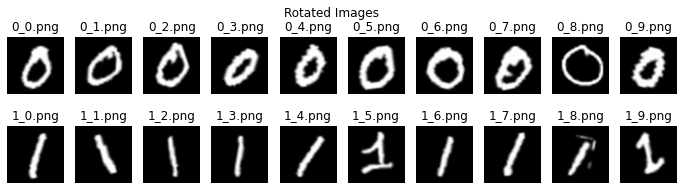

In [110]:
# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], rotated_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], rotated_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.suptitle("Rotated Images", fontsize=12)

As in the previous part, we first apply erosion to the binarized images and then find the contours. Afterwards, we obtained the successive coordinates of the contours and produced the complex signal $u_k $ for each contour pixel. Taking Fourier transform and normalizing them, we obtained Fourier coefficients and considered coefficients other than DC component.

In [111]:
# extract features for rotated imgs
rotated_one_ims = extract_contours(rotated_ones, 120)
rotated_zero_ims = extract_contours(rotated_zeros, 120)

features_r_one = extract_features_one(rotated_one_ims, one_flag=False)
features_r_zero = extract_features_one(rotated_zero_ims)

f_r_one = np.array(features_r_one)
f_r_zero = np.array(features_r_zero)

89
78
75
77
80
141
77
85
65
107
94
94
97
87
94
108
102
102
106
100


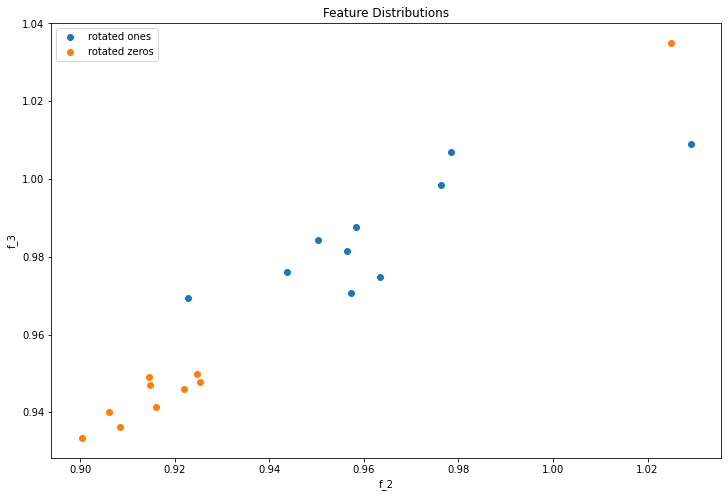

In [112]:
plt.figure(figsize=(12,8))
plt.scatter(f_r_one[:,1], f_r_one[:,2])
plt.scatter(f_r_zero[:,1], f_r_zero[:,2])
plt.title("Feature Distributions")
plt.xlabel('f_2')
plt.ylabel('f_3')
plt.legend(('rotated ones', 'rotated zeros'))

### Invariance to Translation

To show the invariance to translation we will move the objects to different locations and calculate fourier coefficients again.

In [113]:
def move_object_in_image(img, offset):
    """
        params:
            img, numpy.ndarray contains image to be moved by offset amount
        return:
            new_img, numpy.ndarray returns translated version of the given img.
    """
    
    new_img = np.zeros((img.shape[0], img.shape[1]))
    
    old_row_s = (img.shape[0] - 56) // 2
    old_row_e = img.shape[1] - old_row_s 
    
    row_s = old_row_s + offset
    row_e = old_row_e + offset
    
    new_img[old_row_s:old_row_e, old_row_s:old_row_e] = img[row_s:row_e, row_s:row_e]
    
    return new_img

In [114]:
trans_ones = np.zeros((ones_im.shape[0], ones_im.shape[1], ones_im.shape[2]))

offset = -5
for i in range(ones_im.shape[0]):
    img = ones_im[i,:,:]
    # pad images with zeros to size (70, 70)
    padded_img = pad_img(img, (70, 70))
    # translate the objects by offset
    final_m = move_object_in_image(padded_img, offset)
    # crop the object back to original resolution
    trans_ones[i,:,:] = crop_img(final_m, (56,56))
    # update offset to have different translations
    if offset == 5:
        offset = -5
    else:
        offset += 2
    
# same procedures as above
offset = -5
trans_zeros = np.zeros((zeros_im.shape[0], zeros_im.shape[1], zeros_im.shape[2]))
for i in range(zeros_im.shape[0]):
    img = zeros_im[i,:,:]
    padded_img = pad_img(img, (70, 70))
    final_m = move_object_in_image(padded_img, offset)
    trans_zeros[i,:,:] = crop_img(final_m, (56,56))
    if offset == 5:
        offset = -5
    else:
        offset += 2

Text(0.5, 0.98, 'Translated Images')

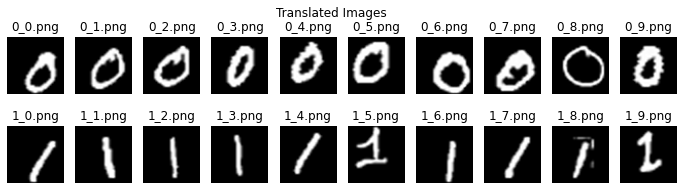

In [115]:
# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], trans_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], trans_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.suptitle('Translated Images', fontsize=12)

In [116]:
# extract feautures from the translates ones and zeros
trans_one_ims = extract_contours(trans_ones, 102)
trans_zero_ims = extract_contours(trans_zeros, 102)

features_t_one = extract_features_one(trans_one_ims, one_flag=False)
features_t_zero = extract_features_one(trans_zero_ims)

f_t_one = np.array(features_t_one)
f_t_zero = np.array(features_t_zero)

83
83
77
77
80
143
79
83
69
106
94
96
95
93
97
109
101
100
107
105


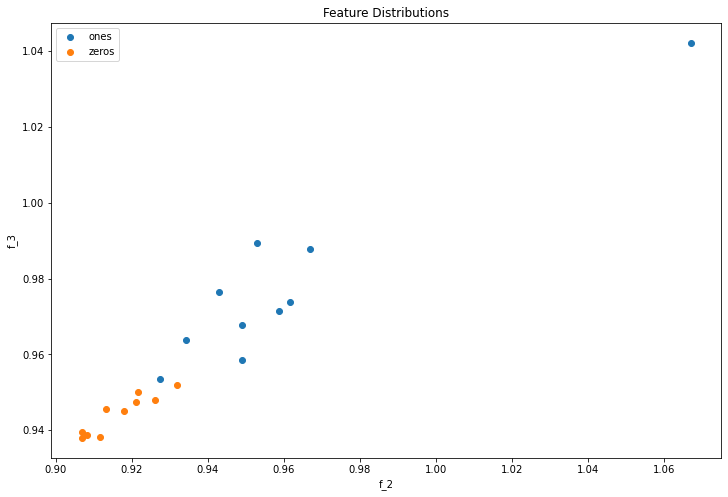

In [117]:
plt.figure(figsize=(12, 8))
plt.scatter(f_t_one[:,1], f_t_one[:,2])
plt.scatter(f_t_zero[:,1], f_t_zero[:,2])
plt.title("Feature Distributions")
plt.xlabel('f_2')
plt.ylabel('f_3')
plt.legend(('ones', 'zeros'))

The locations of Fourier coefficients on the plane are coherent with the locations before translation. 

### Invariance to Scaling

To make our fourier descriptors invariant to scaling we normalize them all by a common coefficient

In [118]:
def embed_img(img):
    """inserts a given image at the center of a (56, 56) black background
    """
    new_img = np.zeros((56, 56))
    
    row_s = (56 - img.shape[0]) // 2
    row_e = 56 - row_s
    
    
    new_img[row_s:row_e, row_s:row_e] = img
    
    return new_img

In [119]:
dim = (56, 56)
scaled_zeros = np.zeros((10, 56, 56))
scaled_ones = np.zeros((10, 56, 56))
# determines the amount of scaling
offset = -30
for i in range(10):
    # scaled zero with new size changed by offset
    new_z = cv.resize(zeros_im[i,:,:], (dim[0] + offset, dim[1] + offset), interpolation = cv.INTER_CUBIC)
    # scaled one with new size changed by offset
    new_o = cv.resize(ones_im[i,:,:], (dim[0] + offset, dim[1] + offset), interpolation = cv.INTER_CUBIC)
    # insert scaled images on a black background image with size (56, 56)
    scaled_zeros[i,:,:] = embed_img(new_z)
    scaled_ones[i,:,:] = embed_img(new_o)
    # update offset to have different scaling factors
    if offset >= 0:
        offset = -30
    else:
        offset += 6    

In [120]:
# extract features for scaled ones and zeros
scaled_one_ims = extract_contours(scaled_ones, 102)
scaled_zero_ims = extract_contours(scaled_zeros, 102)

features_s_one = extract_features_one(scaled_one_ims, one_flag=False)
features_s_zero = extract_features_one(scaled_zero_ims)

f_s_one = np.array(features_s_one)
f_s_zero = np.array(features_s_zero)

31
43
49
59
70
143
30
43
45
84
40
52
62
70
85
109
44
55
70
79


Text(0.5, 0.98, 'Scaled Images')

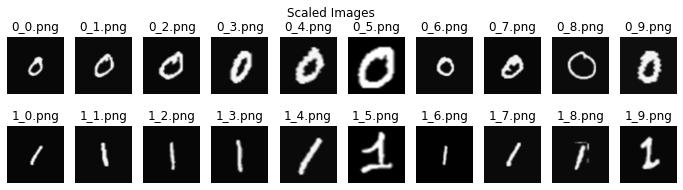

In [121]:
# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], scaled_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], scaled_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
plt.suptitle('Scaled Images', fontsize=12)

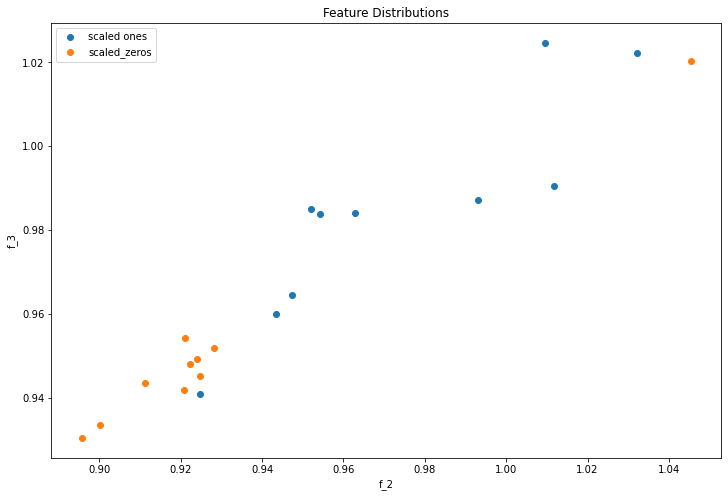

In [122]:
plt.figure(figsize=(12, 8))
plt.scatter(f_s_one[:,1], f_s_one[:,2])
plt.scatter(f_s_zero[:,1], f_s_zero[:,2])
plt.title("Feature Distributions")
plt.xlabel('f_2')
plt.ylabel('f_3')
plt.legend(('scaled ones', 'scaled_zeros'))

### 1.3 Additional method (5 pts)

In the following part, we have chosen to implement a bunch of simple region-based descriptors to see if they separate the numbers properly.

In [123]:
# Add your implementation and discussion

from scipy.ndimage.interpolation import rotate


#function to find the area of the numbers (the number of pixels that form the number)

def find_area(imgs):
    
    imgs[imgs < 102] = 0
    imgs[imgs >= 102] = 255
    
    area = np.zeros(imgs.shape[0])
    for i in range(imgs.shape[0]):
        count_arr = np.bincount(imgs[i].astype('int').flatten())
        area[i] = count_arr[255]
    
    return area


#function to find the perimeter of the numbers (the number of pixels that form the contour of the number)

def find_perim(imgs):
    
    contours = extract_contours(imgs, 102)
    
    size = len(contours)
    
    perim = np.zeros(size)
    for i in range(size):
        count_arr = np.bincount(contours[i][0].astype('int').flatten())
        perim[i] = count_arr[255]
    
    return perim


#function to find the compacity of the numbers (the square of the perimeter over the area)

def find_compac(imgs):
    
    area = find_area(imgs)
    perim = find_perim(imgs)
    
    compac = (perim**2)/area
    
    return compac


#function to find the rectangularity of the numbers (the are of the number over the area of the smallest comscript rectangle to it)

def find_rect(imgs):
    
    area = find_area(imgs)
    
    imgs[imgs < 102] = 0
    imgs[imgs >= 102] = 255
    
    area_rect = np.zeros(imgs.shape[0])
    
    for i in range(imgs.shape[0]):
        area_tmp = 1e14
        for ang in range(180):
            
            padded_img = pad_img(imgs[i], (70, 70))
            rotated = rotate(padded_img, angle=ang)
            rot_img = crop_img(rotated, (56,56))
            
            project_x = np.sum(rot_img, axis=0)
            project_y = np.sum(rot_img, axis=1)
            width_zeros = np.count_nonzero(project_x==0)
            height_zeros = np.count_nonzero(project_y==0)
            width_rect = project_x.size-width_zeros+1
            height_rect = project_y.size-height_zeros+1
            
            wr = width_rect*height_rect
            
            if wr < area_tmp:
                area_tmp = wr

        area_rect[i] = area_tmp
        
    rect = area/area_rect
        
    return rect


#function to find the hight and width of the numbers (the highest values of the projections over the x and y axis respectively)

def projections(imgs):
    
    imgs[imgs < 102] = 0
    imgs[imgs >= 102] = 1
    
    height = np.zeros(imgs.shape[0])
    width = np.zeros(imgs.shape[0])
    
    for i in range(imgs.shape[0]):
        project_x = np.sum(imgs[i], axis=0)
        project_y = np.sum(imgs[i], axis=1)
        height[i] = np.amax(project_x)
        width[i] = np.amax(project_y)
        
    return height, width
    

**Original Samples**

In [124]:
area_zeros = find_area(resized_zeros)
perim_zeros = find_perim(resized_zeros)
compac_zeros = find_compac(resized_zeros)
rect_zeros = find_rect(resized_zeros)

area_ones = find_area(resized_ones)
perim_ones = find_perim(resized_ones)
compac_ones = find_compac(resized_ones)
rect_ones = find_rect(resized_ones)

Text(0, 0.5, 'Rectangularity')

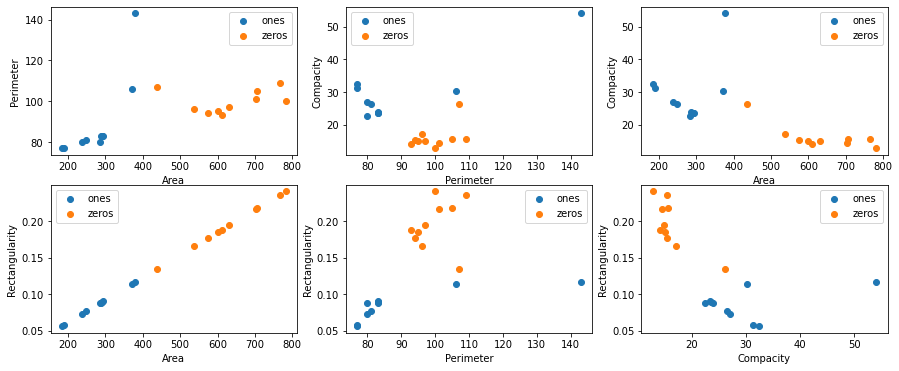

In [125]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,6))

ax1.scatter(area_ones, perim_ones)
ax1.scatter(area_zeros, perim_zeros)
ax1.legend(('ones', 'zeros'))
ax1.set_xlabel('Area')
ax1.set_ylabel('Perimeter')

ax2.scatter(perim_ones, compac_ones)
ax2.scatter(perim_zeros, compac_zeros)
ax2.legend(('ones', 'zeros'))
ax2.set_xlabel('Perimeter')
ax2.set_ylabel('Compacity')

ax3.scatter(area_ones, compac_ones)
ax3.scatter(area_zeros, compac_zeros)
ax3.legend(('ones', 'zeros'))
ax3.set_xlabel('Area')
ax3.set_ylabel('Compacity')

ax4.scatter(area_ones, rect_ones)
ax4.scatter(area_zeros, rect_zeros)
ax4.legend(('ones', 'zeros'))
ax4.set_xlabel('Area')
ax4.set_ylabel('Rectangularity')

ax5.scatter(perim_ones, rect_ones)
ax5.scatter(perim_zeros, rect_zeros)
ax5.legend(('ones', 'zeros'))
ax5.set_xlabel('Perimeter')
ax5.set_ylabel('Rectangularity')

ax6.scatter(compac_ones, rect_ones)
ax6.scatter(compac_zeros, rect_zeros)
ax6.legend(('ones', 'zeros'))
ax6.set_xlabel('Compacity')
ax6.set_ylabel('Rectangularity')

Scatter plots of the different calculated features against one another.

In [126]:
height_zeros, width_zeros = projections(resized_zeros)
height_ones, width_ones = projections(resized_ones)

Text(0, 0.5, 'width')

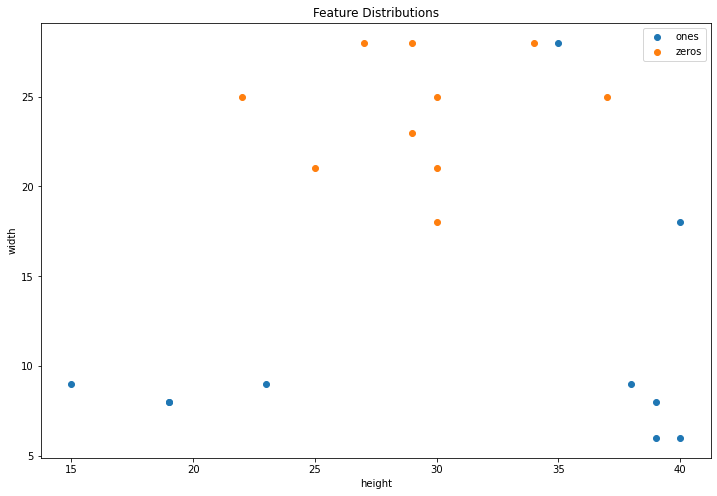

In [127]:
plt.figure(figsize=(12, 8))
plt.scatter(height_ones, width_ones)
plt.scatter(height_zeros, width_zeros)
plt.title("Feature Distributions")
plt.legend(('ones', 'zeros'))
plt.xlabel('height')
plt.ylabel('width')

Scatter plot of the width against the height of the numbers, obtained via projection.

**Rotated Samples**

In [128]:
rotated_area_zeros = find_area(rotated_zeros)
rotated_perim_zeros = find_perim(rotated_zeros)
rotated_compac_zeros = find_compac(rotated_zeros)
rotated_rect_zeros = find_rect(rotated_zeros)

rotated_area_ones = find_area(rotated_ones)
rotated_perim_ones = find_perim(rotated_ones)
rotated_compac_ones = find_compac(rotated_ones)
rotated_rect_ones = find_rect(rotated_ones)

Text(0, 0.5, 'Rectangularity')

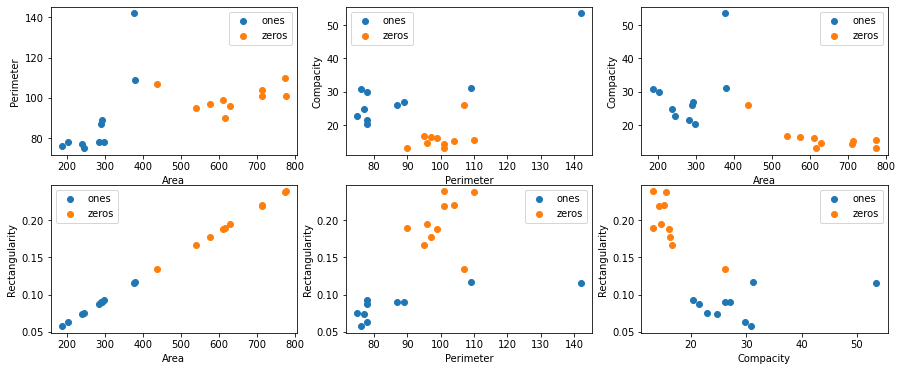

In [129]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,6))

ax1.scatter(rotated_area_ones, rotated_perim_ones)
ax1.scatter(rotated_area_zeros, rotated_perim_zeros)
ax1.legend(('ones', 'zeros'))
ax1.set_xlabel('Area')
ax1.set_ylabel('Perimeter')

ax2.scatter(rotated_perim_ones, rotated_compac_ones)
ax2.scatter(rotated_perim_zeros, rotated_compac_zeros)
ax2.legend(('ones', 'zeros'))
ax2.set_xlabel('Perimeter')
ax2.set_ylabel('Compacity')

ax3.scatter(rotated_area_ones, rotated_compac_ones)
ax3.scatter(rotated_area_zeros, rotated_compac_zeros)
ax3.legend(('ones', 'zeros'))
ax3.set_xlabel('Area')
ax3.set_ylabel('Compacity')

ax4.scatter(rotated_area_ones, rotated_rect_ones)
ax4.scatter(rotated_area_zeros, rotated_rect_zeros)
ax4.legend(('ones', 'zeros'))
ax4.set_xlabel('Area')
ax4.set_ylabel('Rectangularity')

ax5.scatter(rotated_perim_ones, rotated_rect_ones)
ax5.scatter(rotated_perim_zeros, rotated_rect_zeros)
ax5.legend(('ones', 'zeros'))
ax5.set_xlabel('Perimeter')
ax5.set_ylabel('Rectangularity')

ax6.scatter(rotated_compac_ones, rotated_rect_ones)
ax6.scatter(rotated_compac_zeros, rotated_rect_zeros)
ax6.legend(('ones', 'zeros'))
ax6.set_xlabel('Compacity')
ax6.set_ylabel('Rectangularity')

Scatter plots of the different calculated features against one another.

In [130]:
rotated_height_zeros, rotated_width_zeros = projections(rotated_zeros)
rotated_height_ones, rotated_width_ones = projections(rotated_ones)

Text(0, 0.5, 'width')

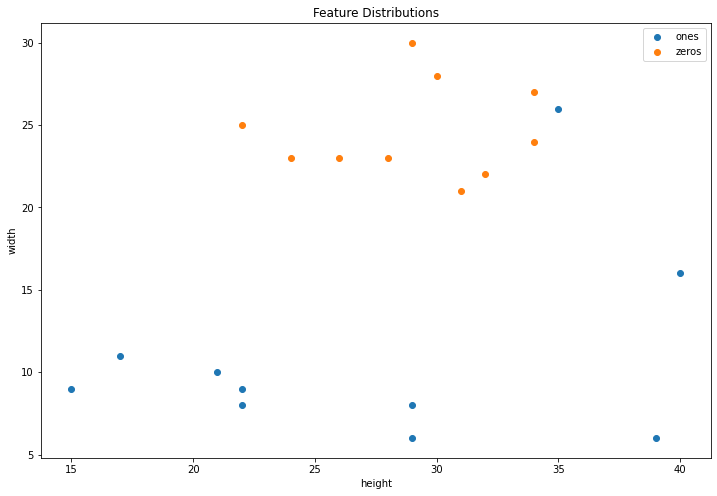

In [131]:
plt.figure(figsize=(12, 8))
plt.scatter(rotated_height_ones, rotated_width_ones)
plt.scatter(rotated_height_zeros, rotated_width_zeros)
plt.title("Feature Distributions")
plt.legend(('ones', 'zeros'))
plt.xlabel('height')
plt.ylabel('width')

Scatter plot of the width against the height of the numbers, obtained via projection.

**Translated Samples**

In [132]:
trans_area_zeros = find_area(trans_zeros)
trans_perim_zeros = find_perim(trans_zeros)
trans_compac_zeros = find_compac(trans_zeros)
trans_rect_zeros = find_rect(trans_zeros)

trans_area_ones = find_area(trans_ones)
trans_perim_ones = find_perim(trans_ones)
trans_compac_ones = find_compac(trans_ones)
trans_rect_ones = find_rect(trans_ones)

Text(0, 0.5, 'Rectangularity')

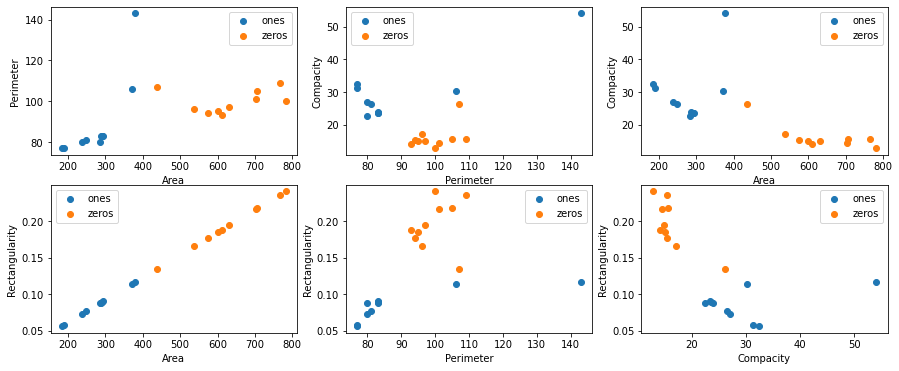

In [133]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,6))

ax1.scatter(trans_area_ones, trans_perim_ones)
ax1.scatter(trans_area_zeros, trans_perim_zeros)
ax1.legend(('ones', 'zeros'))
ax1.set_xlabel('Area')
ax1.set_ylabel('Perimeter')

ax2.scatter(trans_perim_ones, trans_compac_ones)
ax2.scatter(trans_perim_zeros, trans_compac_zeros)
ax2.legend(('ones', 'zeros'))
ax2.set_xlabel('Perimeter')
ax2.set_ylabel('Compacity')

ax3.scatter(trans_area_ones, trans_compac_ones)
ax3.scatter(trans_area_zeros, trans_compac_zeros)
ax3.legend(('ones', 'zeros'))
ax3.set_xlabel('Area')
ax3.set_ylabel('Compacity')

ax4.scatter(trans_area_ones, trans_rect_ones)
ax4.scatter(trans_area_zeros, trans_rect_zeros)
ax4.legend(('ones', 'zeros'))
ax4.set_xlabel('Area')
ax4.set_ylabel('Rectangularity')

ax5.scatter(trans_perim_ones, trans_rect_ones)
ax5.scatter(trans_perim_zeros, trans_rect_zeros)
ax5.legend(('ones', 'zeros'))
ax5.set_xlabel('Perimeter')
ax5.set_ylabel('Rectangularity')

ax6.scatter(trans_compac_ones, trans_rect_ones)
ax6.scatter(trans_compac_zeros, trans_rect_zeros)
ax6.legend(('ones', 'zeros'))
ax6.set_xlabel('Compacity')
ax6.set_ylabel('Rectangularity')

Scatter plots of the different calculated features against one another.

In [134]:
trans_height_zeros, trans_width_zeros = projections(trans_zeros)
trans_height_ones, trans_width_ones = projections(trans_ones)

Text(0, 0.5, 'width')

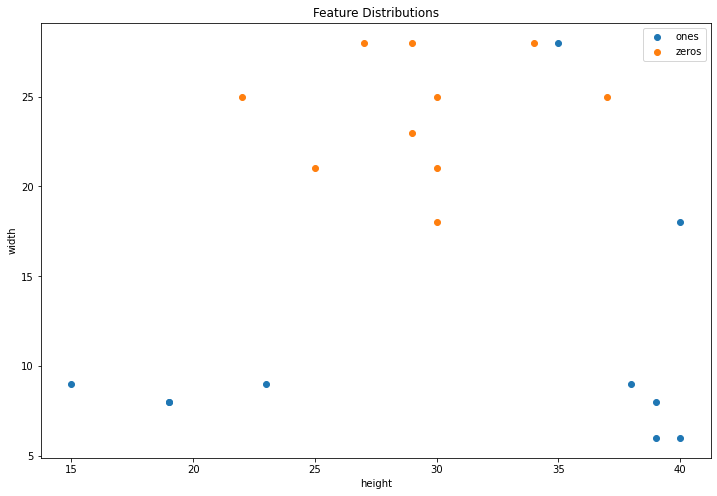

In [135]:
plt.figure(figsize=(12, 8))
plt.scatter(trans_height_ones, trans_width_ones)
plt.scatter(trans_height_zeros, trans_width_zeros)
plt.title("Feature Distributions")
plt.legend(('ones', 'zeros'))
plt.xlabel('height')
plt.ylabel('width')

Scatter plot of the width against the height of the numbers, obtained via projection.

**Scaled Samples**

In [136]:
scaled_area_zeros = find_area(scaled_zeros)
scaled_perim_zeros = find_perim(scaled_zeros)
scaled_compac_zeros = find_compac(scaled_zeros)
scaled_rect_zeros = find_rect(scaled_zeros)

scaled_area_ones = find_area(scaled_ones)
scaled_perim_ones = find_perim(scaled_ones)
scaled_compac_ones = find_compac(scaled_ones)
scaled_rect_ones = find_rect(scaled_ones)

Text(0, 0.5, 'Rectangularity')

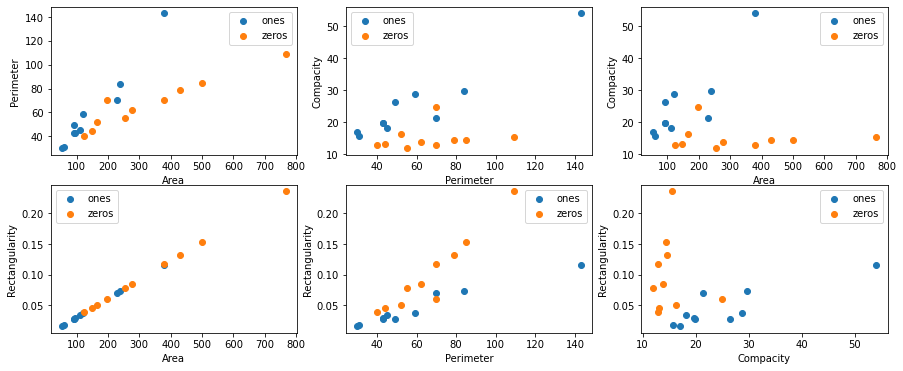

In [137]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,6))

ax1.scatter(scaled_area_ones, scaled_perim_ones)
ax1.scatter(scaled_area_zeros, scaled_perim_zeros)
ax1.legend(('ones', 'zeros'))
ax1.set_xlabel('Area')
ax1.set_ylabel('Perimeter')

ax2.scatter(scaled_perim_ones, scaled_compac_ones)
ax2.scatter(scaled_perim_zeros, scaled_compac_zeros)
ax2.legend(('ones', 'zeros'))
ax2.set_xlabel('Perimeter')
ax2.set_ylabel('Compacity')

ax3.scatter(scaled_area_ones, scaled_compac_ones)
ax3.scatter(scaled_area_zeros, scaled_compac_zeros)
ax3.legend(('ones', 'zeros'))
ax3.set_xlabel('Area')
ax3.set_ylabel('Compacity')

ax4.scatter(scaled_area_ones, scaled_rect_ones)
ax4.scatter(scaled_area_zeros, scaled_rect_zeros)
ax4.legend(('ones', 'zeros'))
ax4.set_xlabel('Area')
ax4.set_ylabel('Rectangularity')

ax5.scatter(scaled_perim_ones, scaled_rect_ones)
ax5.scatter(scaled_perim_zeros, scaled_rect_zeros)
ax5.legend(('ones', 'zeros'))
ax5.set_xlabel('Perimeter')
ax5.set_ylabel('Rectangularity')

ax6.scatter(scaled_compac_ones, scaled_rect_ones)
ax6.scatter(scaled_compac_zeros, scaled_rect_zeros)
ax6.legend(('ones', 'zeros'))
ax6.set_xlabel('Compacity')
ax6.set_ylabel('Rectangularity')

Scatter plots of the different calculated features against one another.

In [138]:
scaled_height_zeros, scaled_width_zeros = projections(scaled_zeros)
scaled_height_ones, scaled_width_ones = projections(scaled_ones)

Text(0, 0.5, 'width')

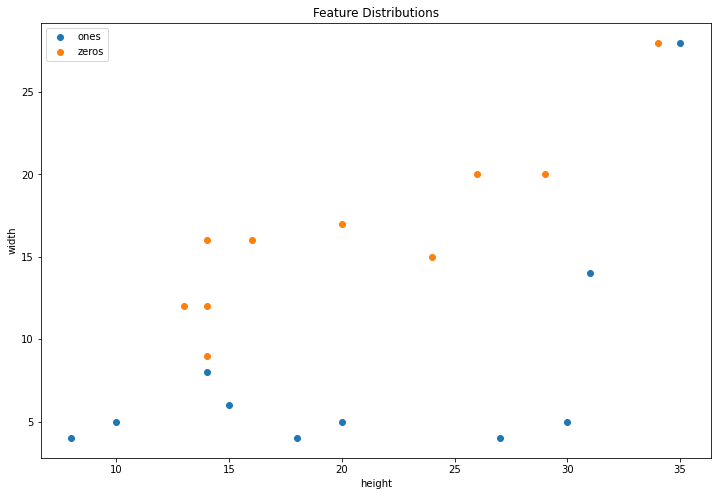

In [139]:
plt.figure(figsize=(12, 8))
plt.scatter(scaled_height_ones, scaled_width_ones)
plt.scatter(scaled_height_zeros, scaled_width_zeros)
plt.title("Feature Distributions")
plt.legend(('ones', 'zeros'))
plt.xlabel('height')
plt.ylabel('width')

Scatter plot of the width against the height of the numbers, obtained via projection.

We notice that the simple descriptors are still pretty effective at separating the digits despite their low level of complexity, and seem to handle rotation and translation pretty well, yet have more trouble handling images with different scales.

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

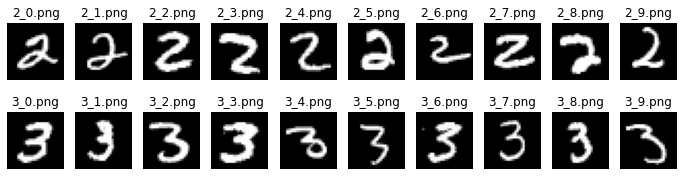

In [140]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

* It is possible to discriminate 4 classes of images with 2 features. However, if both of these features are fourier descriptors, the classes of images should have different frequency characteristics for chosen fourier coefficients. 

* In this example, the digit 2 and digit 3 had similar frequency characteristics, both having similar edges and curves.

* For the case of 0 an 1s, it turns out that fourier descriptors are more useful in that 0s have round curves whereas some 1s have more sharp transitions some 1s are not as curvy as 0s. 

In [141]:
# double the lenght and height of twos and threes
dim = (28*2, 28*2)
r_two_ims = np.zeros((10,*dim))
r_three_ims = np.zeros((10,*dim))
for i in range(10):
    r_two_ims[i,:,:] = cv.resize(twos_im[i,:,:], dim, interpolation = cv.INTER_CUBIC)
    r_three_ims[i,:,:] = cv.resize(threes_im[i,:,:], dim, interpolation = cv.INTER_CUBIC)

In [142]:
# extract the same features as used before
two_ims = extract_contours(r_two_ims, 102)
three_ims = extract_contours(r_three_ims, 102)

features_two = extract_features_one(two_ims)
features_three = extract_features_one(three_ims)

f_two = np.array(features_two)
f_three = np.array(features_three)

143
145
174
165
158
145
136
182
145
133
168
124
174
168
158
130
148
150
128
151


Here we make a 3-D plot using 3 feautures, which are first, second, third fourier coefficients. However, 2 and 3s have very similar fourier coefficients for any degree.

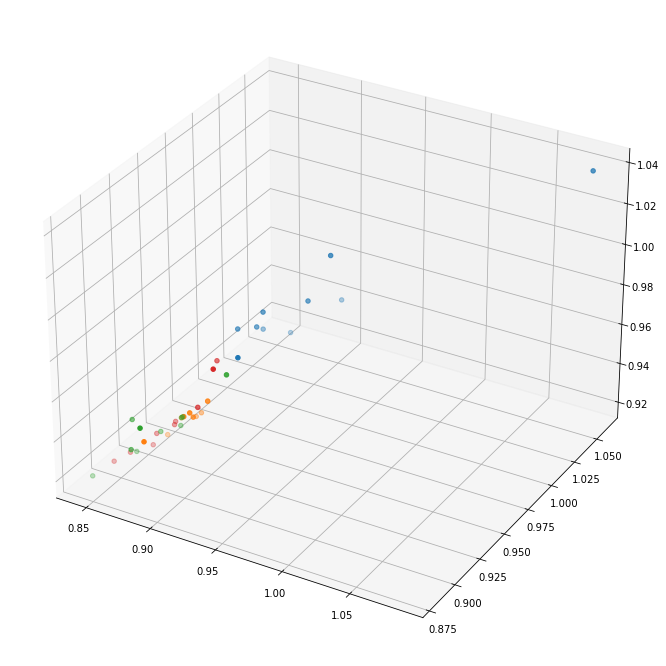

In [143]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.scatter3D(f_one[:,0], f_one[:,1], f_one[:,2],cmap='binary')
ax.scatter3D(f_zero[:,0], f_zero[:,1], f_zero[:,2],cmap='binary')
ax.scatter3D(f_two[:,0], f_two[:,1], f_two[:,2],cmap='binary')
ax.scatter3D(f_three[:,0], f_three[:,1], f_three[:,2],cmap='binary')

* Below, we use the same feautures as part 1. However, fourier descriptors is not a very good feauture for classifying 2s and 3s.

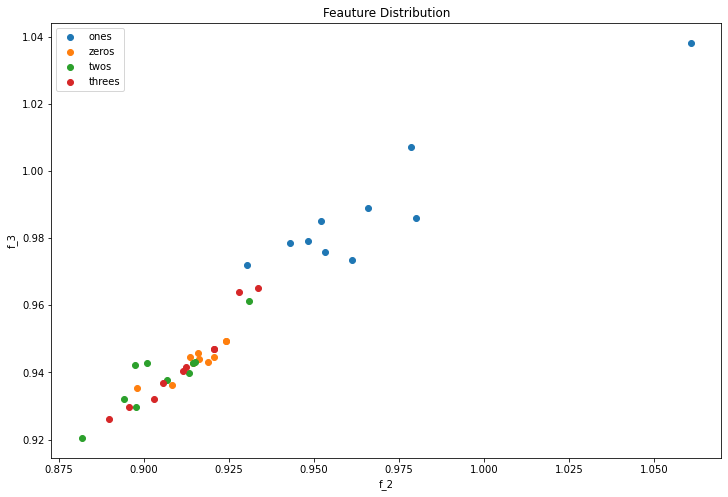

In [144]:
plt.figure(figsize=(12, 8))
plt.scatter(f_one[:,1], f_one[:,2])
plt.scatter(f_zero[:,1], f_zero[: ,2])
plt.scatter(f_two[:,1], f_two[:,2])
plt.scatter(f_three[:,1], f_three[:,2])
plt.title('Feauture Distribution')
plt.xlabel('f_2')
plt.ylabel('f_3')
plt.legend(('ones', 'zeros', 'twos', 'threes'))

**Attempt with the additional descriptors**

In [145]:
area_twos = find_area(r_two_ims)
perim_twos = find_perim(r_two_ims)
compac_twos = find_compac(r_two_ims)
rect_twos = find_rect(r_two_ims)

area_threes = find_area(r_three_ims)
perim_threes = find_perim(r_three_ims)
compac_threes = find_compac(r_three_ims)
rect_threes = find_rect(r_three_ims)

Text(0, 0.5, 'Rectangularity')

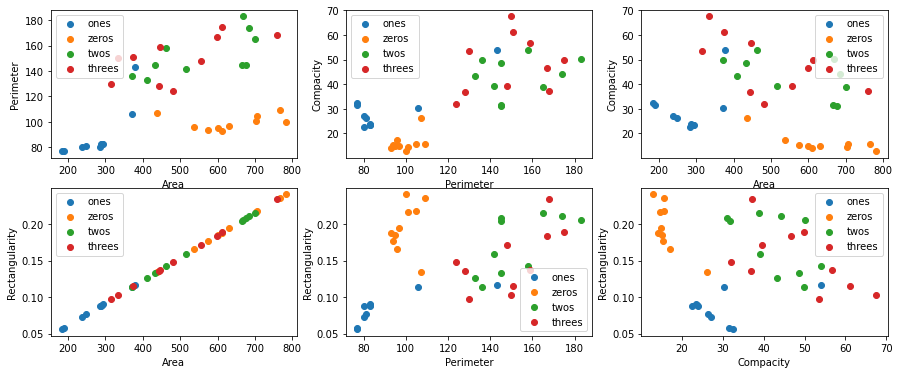

In [146]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,6))

ax1.scatter(area_ones, perim_ones)
ax1.scatter(area_zeros, perim_zeros)
ax1.scatter(area_twos, perim_twos)
ax1.scatter(area_threes, perim_threes)
ax1.legend(('ones', 'zeros', 'twos', 'threes'))
ax1.set_xlabel('Area')
ax1.set_ylabel('Perimeter')

ax2.scatter(perim_ones, compac_ones)
ax2.scatter(perim_zeros, compac_zeros)
ax2.scatter(perim_twos, compac_twos)
ax2.scatter(perim_threes, compac_threes)
ax2.legend(('ones', 'zeros', 'twos', 'threes'))
ax2.set_xlabel('Perimeter')
ax2.set_ylabel('Compacity')

ax3.scatter(area_ones, compac_ones)
ax3.scatter(area_zeros, compac_zeros)
ax3.scatter(area_twos, compac_twos)
ax3.scatter(area_threes, compac_threes)
ax3.legend(('ones', 'zeros', 'twos', 'threes'))
ax3.set_xlabel('Area')
ax3.set_ylabel('Compacity')

ax4.scatter(area_ones, rect_ones)
ax4.scatter(area_zeros, rect_zeros)
ax4.scatter(area_twos, rect_twos)
ax4.scatter(area_threes, rect_threes)
ax4.legend(('ones', 'zeros', 'twos', 'threes'))
ax4.set_xlabel('Area')
ax4.set_ylabel('Rectangularity')

ax5.scatter(perim_ones, rect_ones)
ax5.scatter(perim_zeros, rect_zeros)
ax5.scatter(perim_twos, rect_twos)
ax5.scatter(perim_threes, rect_threes)
ax5.legend(('ones', 'zeros', 'twos', 'threes'))
ax5.set_xlabel('Perimeter')
ax5.set_ylabel('Rectangularity')

ax6.scatter(compac_ones, rect_ones)
ax6.scatter(compac_zeros, rect_zeros)
ax6.scatter(compac_twos, rect_twos)
ax6.scatter(compac_threes, rect_threes)
ax6.legend(('ones', 'zeros', 'twos', 'threes'))
ax6.set_xlabel('Compacity')
ax6.set_ylabel('Rectangularity')

Looking at the other descriptors we implemented, we notice that for the most part it is able to separate the ones and zeros from each others and from the twos and threes but it still has trouble separating the twos and threes from one another.